# Image Classification

## Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... done
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/fb/m_kwsy5975zfb_gqjhhn2p6h0000gn/T/pip-install-8p9vj9e2/tensorflow-gpu_48cabc2282894f8f8056fe4be104b983/setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      


In [2]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
anyio                        3.7.1
appnope                      0.1.3
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.3
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bidict                       0.22.1
biosppy                      2.1.0
bleach                       6.0.0
cachetools                   5.3.2
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           3.2.0
comm                         0.1.3
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1


In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OMM errors by setting GPU Memory Comsumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

## Removing Dodgy Images

In [6]:
import os
import cv2

In [7]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            file_ext = image_path.split('.')[-1].lower()  # Dosya uzantısını al
            if file_ext not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)


## Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [15]:
# Class 1 = SAD
# Class 0 = HAPPY
batch[1]

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0], dtype=int32)

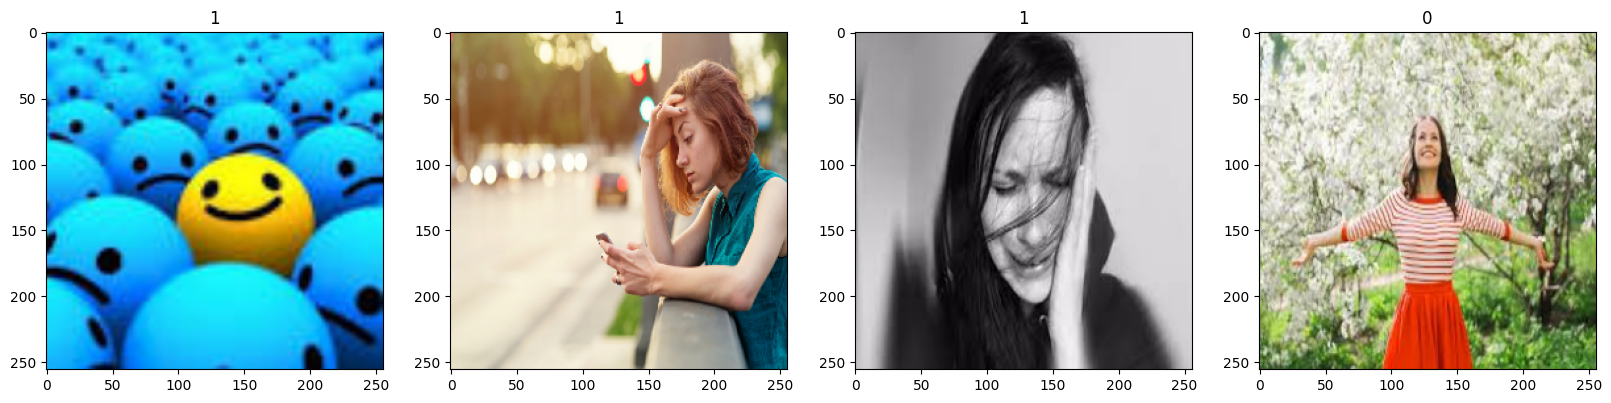

In [16]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
scaled_iterator = data.as_numpy_iterator()

In [19]:
batch = scaled_iterator.next()

In [20]:
batch[0].max()

1.0

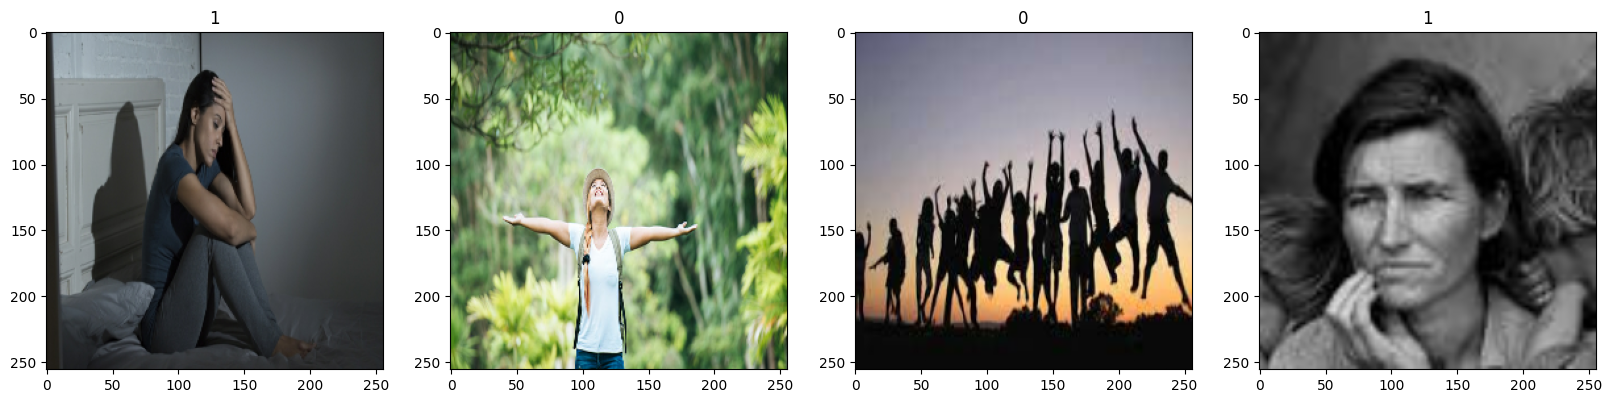

In [21]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Split Data

In [22]:
len(data)

10

In [23]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [24]:
train_size

7

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Build Deep Learning Model

In [26]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

## Train

In [32]:
logdir = 'logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 4s 437ms/step - loss: 1.5315 - accuracy: 0.4955 - val_loss: 0.7196 - val_accuracy: 0.4688
Epoch 2/20
7/7 [==============================] - 4s 428ms/step - loss: 0.6932 - accuracy: 0.5848 - val_loss: 0.6740 - val_accuracy: 0.6719
Epoch 3/20
7/7 [==============================] - 4s 423ms/step - loss: 0.6785 - accuracy: 0.5670 - val_loss: 0.6071 - val_accuracy: 0.8125
Epoch 4/20
7/7 [==============================] - 4s 424ms/step - loss: 0.6467 - accuracy: 0.6339 - val_loss: 0.6014 - val_accuracy: 0.8438
Epoch 5/20
7/7 [==============================] - 4s 429ms/step - loss: 0.5680 - accuracy: 0.8527 - val_loss: 0.5011 - val_accuracy: 0.7031
Epoch 6/20
7/7 [==============================] - 4s 429ms/step - loss: 0.4736 - accuracy: 0.7857 - val_loss: 0.3547 - val_accuracy: 0.8438
Epoch 7/20
7/7 [==============================] - 4s 425ms/step - loss: 0.4260 - accuracy: 0.8616 - val_loss: 0.7401 - val_accuracy: 0.6875
Epoch 8/20
7/7 [====

## Plot Performance

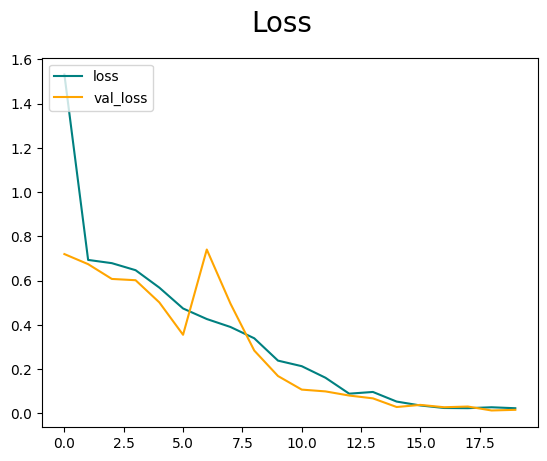

In [35]:
fig = plt.figure()

plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')

fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

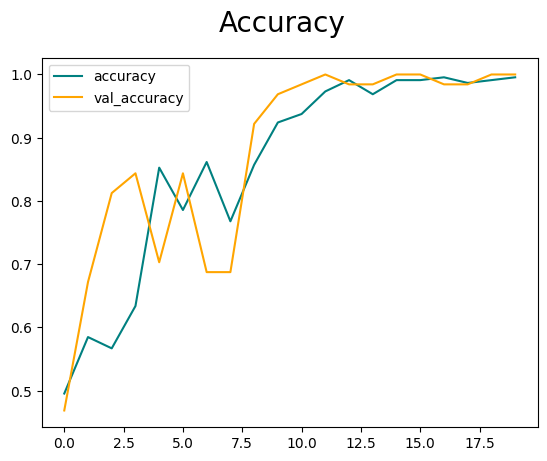

In [36]:
fig = plt.figure()

plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')

fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
len(test)

1

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 65ms/step


In [41]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


## Test

In [42]:
import cv2

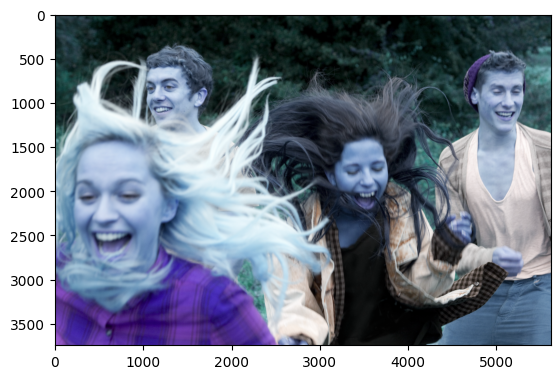

In [43]:
img = cv2.imread('happytest.jpg')
plt.imshow(img)
plt.show()

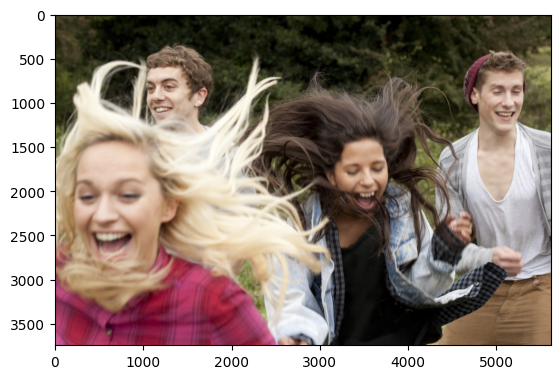

In [44]:
img = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

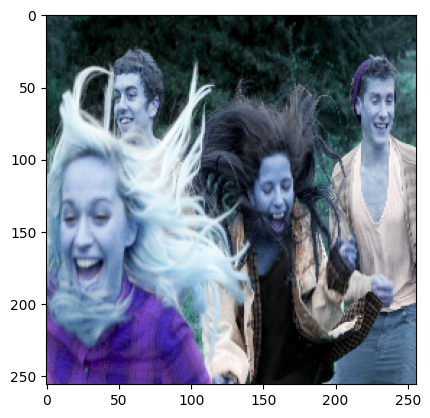

In [45]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 13ms/step


In [47]:
yhat

array([[0.03324556]], dtype=float32)

In [48]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


## Save the Model

In [49]:
from tensorflow.keras.models import load_model

In [50]:
model.save(os.path.join('models','imageclassifier.h5'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
new_model = load_model('models/imageclassifier.h5')

In [55]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 35ms/step


array([[0.03324556]], dtype=float32)